# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

# Common imports

In [100]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Part (a)

In [2]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [76]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    M = np.zeros((len(matches),9))
    for i in range(len(matches)):
        u = matches[i][0]
        v = matches[i][1]
        u_ = matches[i][2]
        v_ = matches[i][3]
        M[i] = [u*u_, u_*v, u_, v_*u, v_*v, v_, u, v, 1 ]
    u, s, v = np.linalg.svd(M)
    F = v[len(v)-1]  
    u, s, v = np.linalg.svd(F.reshape(3,3))
    s, s[-1]= np.diag(s), 0
    F = np.matmul(u, np.matmul(s, v))
    return F

def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """
    T1, T2 =  [[np.sqrt(2)/np.std(matches[:,0]), 0, -np.sqrt(2)/np.std(matches[:,0])*np.mean(matches[:,0:2], axis = 0)[0]], 
              [0, np.sqrt(2)/np.std(matches[:,1]), -np.sqrt(2)/np.std(matches[:,1])*np.mean(matches[:,0:2], axis = 0)[1]], 
              [0, 0, 1]], [[np.sqrt(2)/np.std(matches[:,2]), 0, -np.sqrt(2)/np.std(matches[:,2])*np.mean(matches[:,2:4], axis = 0)[0]], 
              [0, np.sqrt(2)/np.std(matches[:,3]), -np.sqrt(2)/np.std(matches[:,3])*np.mean(matches[:,2:4], axis = 0)[1]], 
              [0, 0, 1]]
    
    norm_matches = np.zeros((len(matches), len(matches[0])))
    p1 = np.concatenate((matches[:,0:2], np.ones((len(matches),1))), axis = 1)
    p2 = np.concatenate((matches[:,2:4], np.ones((len(matches),1))), axis = 1)
    norm_matches[:,0:2] = (np.matmul(T1, p1.T).T)[:,0:2]
    norm_matches[:,2:4] = (np.matmul(T2, p2.T).T)[:,0:2]
    
    
    M = np.zeros((len(matches),9))
    for i in range(len(matches)):
        u = norm_matches[i][0]
        v = norm_matches[i][1]
        u_ = norm_matches[i][2]
        v_ = norm_matches[i][3]
        M[i] = [u*u_, u_*v, u_, v_*u, v_*v, v_, u, v, 1 ]
    u, s, v = np.linalg.svd(M)
    F = v[len(v)-1]  
    u, s, v = np.linalg.svd(F.reshape(3,3))
    s, s[-1]= np.diag(s), 0
    F = np.matmul(u, np.matmul(s, v))
    F = np.matmul(np.matmul(np.transpose(T2), F), T1)
    return F

library: residual in frame 2 (non-normalized method) =  0.17921336680315691
library: residual in frame 1 (non-normalized method) =  0.14912309938770843
library: residual combined   (non-normalized method) =  0.16416823309543266
library: residual in frame 2 (normalized method) =  0.0603408763677758
library: residual in frame 1 (normalized method) =  0.0548874148563629
library: residual combined   (normalized method) =  0.057614145612069345


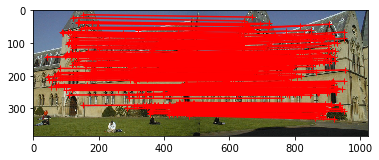

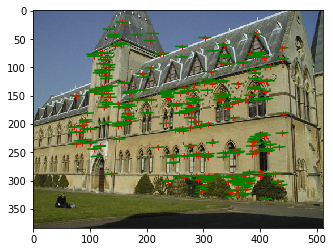

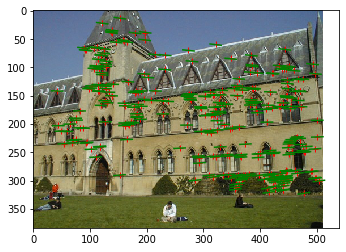

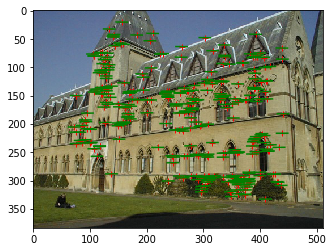

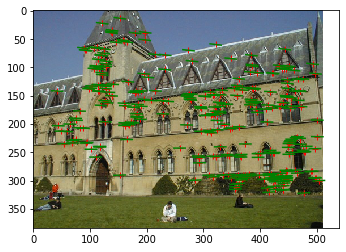

In [78]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./data/Q2/{:s}1.jpg'.format(name))
I2 = Image.open('./data/Q2/{:s}2.jpg'.format(name))
matches = np.loadtxt('./data/Q2/{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# # non-normalized method
F = fit_fundamental(matches) 
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

# Part (b)

In [137]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(pts_3d, pts_2d):
    """
    write your code to compute camera matrix
    """
    A = np.zeros((len(pts_3d)*2, 12))
    for i in range(len(pts_3d)):
        temp = np.concatenate((pts_3d[i], [1]), axis = 0)
        A[2*i,4:8] = temp
        A[2*i,8:12] = -pts_2d[i, 1]*temp
        A[2*i+1,0:4] = temp
        A[2*i+1,8:12] = -pts_2d[i, 0]*temp
    u, s, v = np.linalg.svd(A)
    A = v[len(v)-1].reshape(3,4)
    return A


# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./data/Q2/lab_3d.txt')
matches = np.loadtxt('./data/Q2/lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pts_3d, matches[:,0:2])
lab2_proj = camera_calibration(pts_3d, matches[:,2:4])
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, matches[:,0:2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab2_proj, matches[:,2:4], pts_3d)
print('residual in lab2:', lab2_res)

lab 1 camera projection
[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]

lab 2 camera projection
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.54583290423828
residual in lab2: 15.544953444285387


In [138]:
lib1_proj = np.loadtxt('./data/Q2/library1_camera.txt')
lib2_proj = np.loadtxt('./data/Q2/library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


# Part (c)

In [139]:
# Write your code here for computing camera centers
def calc_camera_center(M):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>
    u, s, v = np.linalg.svd(M)
    c = v[len(v)-1]/v[len(v)-1][-1]
    return c

# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.83276769 304.20103826  30.13699243   1.        ]
lab2 camera center [303.10003925 307.18428016  30.42166874   1.        ]
library1 camera center [  7.28863053 -21.52118112  17.73503585   1.        ]
library2 camera center [  6.89405488 -15.39232716  23.41498687   1.        ]


# Part (d)

Mean 3D reconstuction error for the lab data:  41.27285
2D reprojection error for the lab 1 data:  24.31825303742564
2D reprojection error for the lab 2 data:  3.9232806939813862
2D reprojection error for the library 1 data:  51.532271221300746
2D reprojection error for the library 2 data:  81.28132134991958


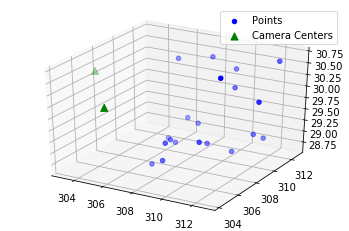

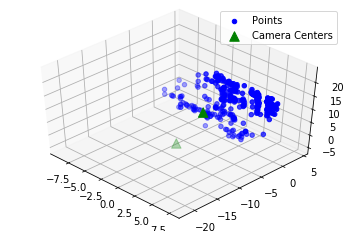

In [149]:
# Write your code here for triangulation
def triangulation(proj1, proj2, matches):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    points_3d = np.zeros((len(matches), 4))
    for i in range(len(matches)):
        M1 = np.array([[0, -1, matches[i,1]], 
                          [1, 0, -matches[i,0]], 
                          [-matches[i,1], matches[i,0], 0]])

        M2 = np.array([[0, -1, matches[i,3]], 
                          [1, 0, -matches[i,2]], 
                          [-matches[i,3], matches[i,2], 0]])
        M = np.concatenate((np.matmul(M1, proj1), np.matmul(M2, proj2))) 
        u, s, v = np.linalg.svd(M)
        points_3d[i] = v[len(v)-1]/v[len(v)-1][-1]
    return points_3d

def evaluate_points_3d(lab1_proj, lab2_proj, points_3d_lab, matches_lab):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    M1 = np.matmul(lab1_proj, points_3d_lab.T).T
    M1 = M1/M1[:, -1][:, np.newaxis]
    M2 = np.matmul(lab2_proj, points_3d_lab.T).T
    M2 = M2/M2[:, -1][:, np.newaxis]
    M = np.concatenate((M1[:,0:2], M2[:,0:2]), axis = 1)
    res = np.linalg.norm(M-matches_lab)**2
    return np.mean(res)

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./data/Q2/lab_matches.txt')
points_3d_gt = np.loadtxt('./data/Q2/lab_3d.txt')
points_3d_lab = triangulation(lab1_proj, lab2_proj, matches_lab) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(lab1_proj, lab2_proj,points_3d_lab, matches_lab) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, matches_lab[:,0:2], points_3d_lab[:,0:3])
_, res_2d_lab2 = evaluate_points(lab2_proj, matches_lab[:,2:4], points_3d_lab[:,0:3])
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')

# # triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./data/Q2/library_matches.txt')
points_3d_lib = triangulation(lib1_proj, lib2_proj, matches_lib) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, matches_lib[:,0:2], points_3d_lib[:,0:3])
_, res_2d_lib2 = evaluate_points(lib2_proj, matches_lib[:,2:4], points_3d_lib[:,0:3])
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')